In [183]:
# Data cleaning and engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.lower_bounds = None
        self.upper_bounds = None

    def fit(self, X, y=None):
        self.lower_bounds = np.quantile(X, self.lower_quantile, axis=0)
        self.upper_bounds = np.quantile(X, self.upper_quantile, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.lower_bounds, self.upper_bounds)

class YearConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.min_year = None
        self.max_year = None

    def fit(self, X, y=None):
        X_flat = X.ravel() if X.ndim > 1 else X
        self.min_year = np.min(X_flat)
        self.max_year = min(np.max(X_flat), pd.Timestamp.now().year)
        return self

    def transform(self, X):
        X_numeric = pd.to_numeric(X.ravel() if X.ndim > 1 else X, errors='coerce')
        X_clipped = np.clip(X_numeric, self.min_year, self.max_year)
        return X_clipped.reshape(X.shape)

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Create new features
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        
        current_year = pd.Timestamp.now().year
        X['HouseAge'] = current_year - X['YearBuilt']
        X['TimeSinceRemodel'] = current_year - X['YearRemodAdd']
        
        X['TotalBathrooms'] = X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath'])
        X['IsNewHouse'] = (X['YearBuilt'] == X['YrSold']).astype(int)
        X['HasPool'] = (X['PoolArea'] > 0).astype(int)
        X['TotalPorchSF'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        X['OverallHouseCondition'] = X['OverallQual'] * X['OverallCond']
        
        # Create interaction features
        X['TotalSF_OverallQual'] = X['TotalSF'] * X['OverallQual']
        X['GrLivArea_TotRmsAbvGrd'] = X['GrLivArea'] * X['TotRmsAbvGrd']
        X['HouseAge_OverallQual'] = X['HouseAge'] * X['OverallQual']
        X['GarageArea_GarageCars'] = X['GarageArea'] * X['GarageCars']
        X['YearBuilt_YearRemodAdd'] = X['YearBuilt'] * X['YearRemodAdd']
        X['TotalSF_HouseAge'] = X['TotalSF'] * X['HouseAge']
        X['1stFlrSF_2ndFlrSF'] = X['1stFlrSF'] * X['2ndFlrSF']
        X['TotalSF_OverallCond'] = X['TotalSF'] * X['OverallCond']
        
        # Interaction with categorical variable (requires encoding)
        X['GrLivArea_Neighborhood'] = X['GrLivArea'] * pd.factorize(X['Neighborhood'])[0]
        
        return X

def pandas_to_numpy(X):
    return X.to_numpy() if isinstance(X, pd.DataFrame) else X

def preprocess_and_engineer(X):
    # Apply FeatureEngineer first
    feature_engineer = FeatureEngineer()
    X_engineered = feature_engineer.fit_transform(X.copy())
    
    # Identify numeric, categorical, and year columns
    numeric_features = X_engineered.select_dtypes(include=['int64', 'float64']).columns.drop(['YearBuilt', 'YearRemodAdd', 'YrSold'])
    categorical_features = X_engineered.select_dtypes(include=['object']).columns
    year_features = ['YearBuilt', 'YearRemodAdd', 'YrSold']
    
    print("Number of features before preprocessing:")
    print(f"Numeric: {len(numeric_features)}")
    print(f"Categorical: {len(categorical_features)}")
    print(f"Year: {len(year_features)}")
    
    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('outlier_capper', OutlierCapper()),
        ('scaler', StandardScaler()),
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', max_categories=10)),
    ])

    year_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('converter', YearConverter()),
    ])

    # Create and fit the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('year', year_transformer, year_features)
        ])
    
    X_preprocessed = preprocessor.fit_transform(X_engineered)
    
    # Generate feature names
    numeric_feature_names = list(numeric_features)
    categorical_feature_names = []
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    
    print("\nCategorical feature encoding details:")
    for i, feature in enumerate(categorical_features):
        categories = onehot_encoder.categories_[i]
        n_categories = min(len(categories), 10)  # Account for max_categories=10
        n_encoded = n_categories - 1  # Subtract 1 due to drop='first'
        print(f"{feature}: {n_categories} categories, {n_encoded} encoded features")
        categorical_feature_names.extend([f"{feature}_{cat}" for cat in categories[1:n_categories]])
    
    year_feature_names = list(year_features)
    
    feature_names = (numeric_feature_names + 
                     categorical_feature_names + 
                     year_feature_names)
    
    print("\nNumber of features after preprocessing:")
    print(f"Numeric: {len(numeric_feature_names)}")
    print(f"Categorical (one-hot encoded): {len(categorical_feature_names)}")
    print(f"Year: {len(year_feature_names)}")
    
    print(f"\nTotal number of features: {len(feature_names)}")
    print(f"Number of columns in preprocessed data: {X_preprocessed.shape[1]}")
    
    # Ensure the number of feature names matches the number of columns in X_preprocessed
    if len(feature_names) != X_preprocessed.shape[1]:
        print(f"\nWarning: Number of feature names ({len(feature_names)}) "
              f"does not match number of columns in preprocessed data ({X_preprocessed.shape[1]})")
        print("Adjusting feature names...")
        if len(feature_names) > X_preprocessed.shape[1]:
            feature_names = feature_names[:X_preprocessed.shape[1]]
        else:
            feature_names += [f'Unknown_{i}' for i in range(X_preprocessed.shape[1] - len(feature_names))]
    
    # Store feature names as an attribute of the DataFrame
    df = pd.DataFrame(X_preprocessed, columns=feature_names, index=X.index)
    df.attrs['feature_names'] = feature_names
    
    return df

# Load the data
df = pd.read_csv('/Users/ttanaka/Desktop/Website/house-prices-advanced-regression-techniques/train.csv')

# Separate features and target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Full pipeline
full_pipeline = Pipeline([
    ('preprocess_and_engineer', FunctionTransformer(preprocess_and_engineer, validate=False)),
    ('to_numpy', FunctionTransformer(pandas_to_numpy))
])

# Apply the pipeline
X_processed = full_pipeline.fit_transform(X)

# Validation
print("\nFinal validation:")
print("Shape after preprocessing:", X_processed.shape)
print("Missing values after preprocessing:", np.isnan(X_processed).sum())

# Access feature names from the intermediate DataFrame
intermediate_df = full_pipeline.named_steps['preprocess_and_engineer'].transform(X)
feature_names = intermediate_df.attrs.get('feature_names', [])
print("Number of features:", len(feature_names))
print("First 10 feature names:", feature_names[:10])
print("Last 10 feature names:", feature_names[-10:])

Number of features before preprocessing:
Numeric: 51
Categorical: 43
Year: 3

Categorical feature encoding details:
MSZoning: 5 categories, 4 encoded features
Street: 2 categories, 1 encoded features
Alley: 3 categories, 2 encoded features
LotShape: 4 categories, 3 encoded features
LandContour: 4 categories, 3 encoded features
Utilities: 2 categories, 1 encoded features
LotConfig: 5 categories, 4 encoded features
LandSlope: 3 categories, 2 encoded features
Neighborhood: 10 categories, 9 encoded features
Condition1: 9 categories, 8 encoded features
Condition2: 8 categories, 7 encoded features
BldgType: 5 categories, 4 encoded features
HouseStyle: 8 categories, 7 encoded features
RoofStyle: 6 categories, 5 encoded features
RoofMatl: 8 categories, 7 encoded features
Exterior1st: 10 categories, 9 encoded features
Exterior2nd: 10 categories, 9 encoded features
MasVnrType: 5 categories, 4 encoded features
ExterQual: 4 categories, 3 encoded features
ExterCond: 5 categories, 4 encoded features

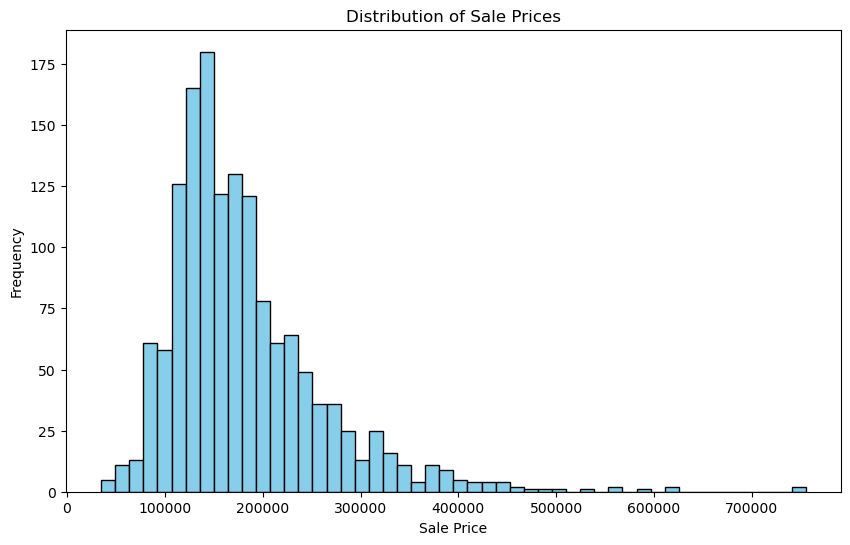

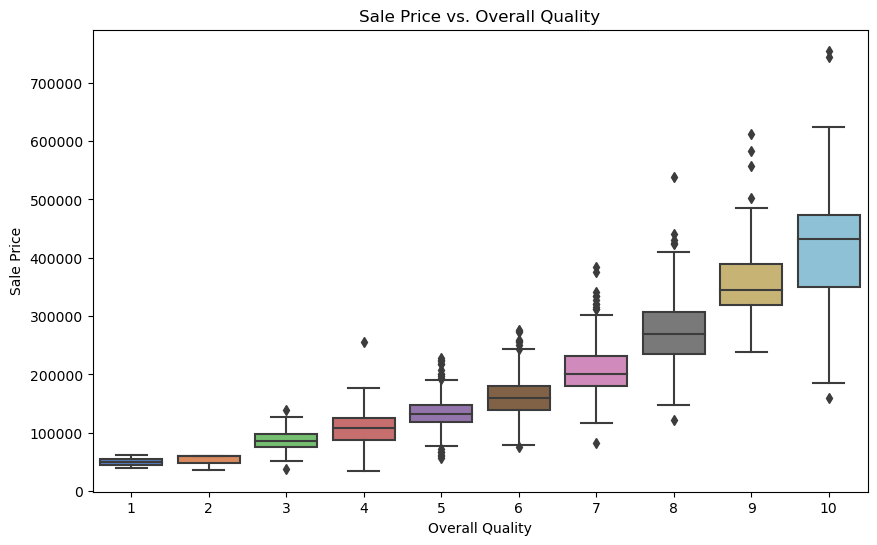

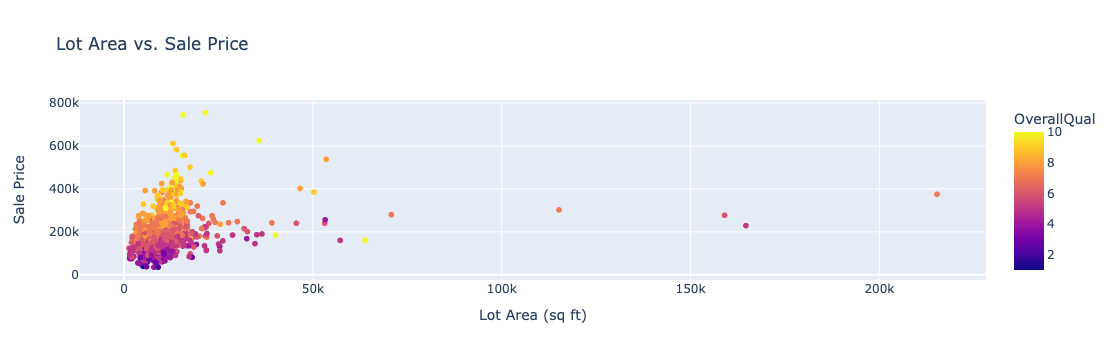

Top correlated features with SalePrice:
 Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


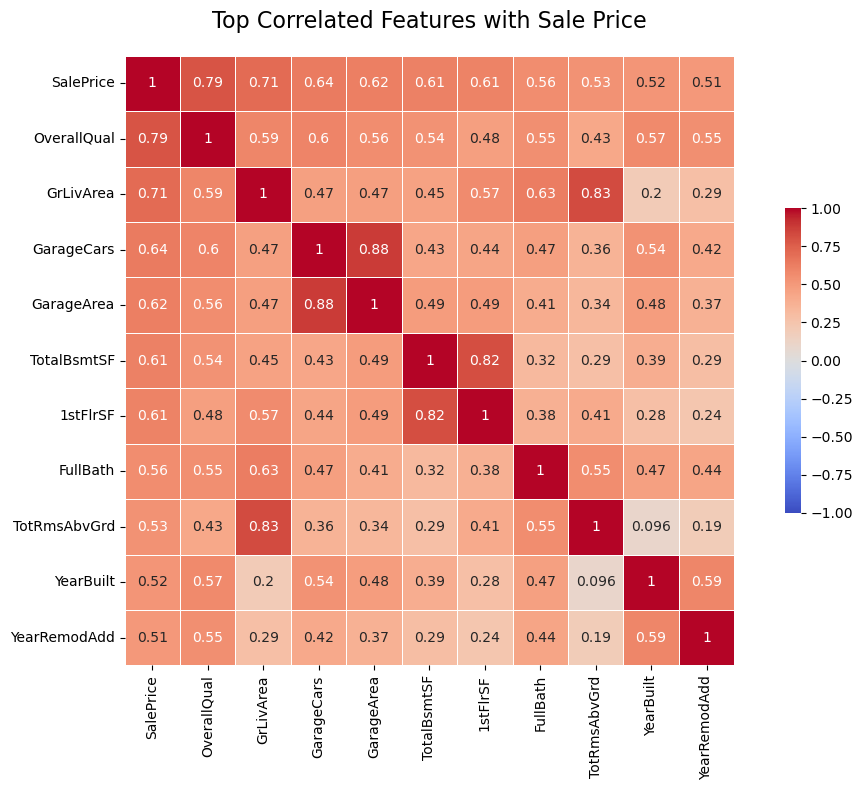

In [184]:
# Visualizations

# Sale Price Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['SalePrice'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.savefig('matplotlib_sale_price_distribution.png')
plt.show()

# Sale Price vs. Overall Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='muted')
plt.title('Sale Price vs. Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.savefig('seaborn_sale_price_vs_quality.png')
plt.show()

# Create a scatter plot using Plotly
fig = px.scatter(df, x='LotArea', y='SalePrice', color='OverallQual',
                 title='Lot Area vs. Sale Price',
                 labels={'LotArea': 'Lot Area (sq ft)', 'SalePrice': 'Sale Price'},
                 hover_data=['YearBuilt'])
# Display the plot
fig.show()
# Save the plot as a PNG image
fig.write_image('plotly_lot_area_vs_sale_price.png')

# Compute the correlation matrix
corr_matrix = df.corr()
# Select the top features that correlate with 'SalePrice'
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(11).index
print("Top correlated features with SalePrice:\n", top_corr_features)
# Create a new correlation matrix with the top features
top_corr_matrix = df[top_corr_features].corr()
# Create the heatmap
plt.figure(figsize=(11, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True, 
            linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Top Correlated Features with Sale Price', fontsize=16, pad=20)
plt.tight_layout()
# Save the plot
plt.savefig('seaborn_top_corr_heatmap.png')
# Display the plot
plt.show()

In [185]:
# univariate feature selection

from sklearn.feature_selection import SelectKBest, f_regression

# This uses f_regression, which is appropriate for regression problems
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X_processed, y)

selected_feature_indices = selector.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_feature_indices]

print("\nTop 10 features selected by univariate feature selection (using f_regression):")
print(selected_features)


Top 10 features selected by univariate feature selection (using f_regression):
['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'TotalSF', 'TotalBathrooms', 'TotalSF_OverallQual', 'GrLivArea_TotRmsAbvGrd', 'GarageArea_GarageCars', 'TotalSF_OverallCond']


In [186]:
# Top features selected by RFE

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Use X_processed instead of X
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_processed, y)

# Get the mask of selected features
feature_mask = selector.support_

# Get the names of the selected features
selected_features = [feature_names[i] for i in range(len(feature_mask)) if feature_mask[i]]

print("Top 10 features selected by RFE:")
print(selected_features)

Top 10 features selected by RFE:
['Condition2_PosN', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'PoolQC_Fa', 'PoolQC_missing']


In [187]:
# Top features selected by Random Forest

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Use X_processed instead of X
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_processed, y)

# Get feature importances
importances = rf_model.feature_importances_

# Sort features by importance
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 features by Random Forest importance:")
print(feature_importance_df.head(10))

Top 10 features by Random Forest importance:
                  feature  importance
0     TotalSF_OverallQual    0.807735
1     TotalSF_OverallCond    0.016542
2  YearBuilt_YearRemodAdd    0.010114
3                 LotArea    0.008518
4              BsmtFinSF1    0.008383
5               BsmtUnfSF    0.007986
6             OpenPorchSF    0.007166
7   GarageArea_GarageCars    0.006161
8    HouseAge_OverallQual    0.005684
9          TotalBathrooms    0.005231


In [188]:
# Top features selected by XGBoost

import xgboost as xgb
import pandas as pd
import numpy as np

# Convert X_processed to a DataFrame if it's not already
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# Ensure all data is numeric
for col in X_processed_df.columns:
    if X_processed_df[col].dtype == 'object':
        X_processed_df[col] = pd.factorize(X_processed_df[col])[0]

# Now fit the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_processed_df, y)

# Get feature importances
importances = xgb_model.feature_importances_

# Sort features by importance
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 features by XGBoost importance:")
print(feature_importance_df.head(10))

Top 10 features by XGBoost importance:
                feature  importance
0   TotalSF_OverallQual    0.432219
1        KitchenQual_TA    0.071039
2         Alley_missing    0.054369
3  Neighborhood_Blueste    0.029859
4         GarageQual_TA    0.028146
5         LandSlope_Mod    0.027403
6           MSZoning_RM    0.018765
7            GarageCars    0.018041
8          KitchenAbvGr    0.015699
9          SaleType_New    0.014757


In [189]:
# OLS regression

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import numpy as np

# Fit OLS model
ols = LinearRegression()
ols.fit(X_processed, y)

def mean_squared_log_error(y_true, y_pred):
    # Add a small constant to avoid log(0)
    y_true = np.maximum(y_true, 0) + 1
    y_pred = np.maximum(y_pred, 0) + 1
    return np.mean(np.square(np.log(y_true) - np.log(y_pred)))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the scoring metrics
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'MSLE': make_scorer(mean_squared_log_error, greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'MedAE': 'neg_median_absolute_error',
    'R2': 'r2',
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
}

# Perform cross-validation with multiple metrics
cv_results = cross_validate(ols, X_processed, y, cv=5, scoring=scoring)

# Print results
for metric, scores in cv_results.items():
    if metric.startswith('test_'):
        metric_name = metric[5:]  # Remove 'test_' prefix
        if metric_name in ['MAE', 'MSE', 'MSLE', 'MAPE', 'MedAE', 'RMSE']:
            print(f"{metric_name}: {-scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        else:  # R2 score
            print(f"{metric_name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Calculate RMSE from MSE for comparison
mse = -cv_results['test_MSE'].mean()
rmse = np.sqrt(mse)
print(f"RMSE (calculated from MSE): {rmse:.4f}")

# Get coefficients
ols_coef = pd.DataFrame({'feature': feature_names, 'coefficient': ols.coef_})
print("\nTop 5 positive and negative OLS coefficients:")
print(ols_coef.sort_values('coefficient', ascending=False).head())
print(ols_coef.sort_values('coefficient', ascending=True).head())

MAE: 18646.6195 (+/- 2643.2246)
MSE: 1377330606.2392 (+/- 982155553.6464)
MSLE: 0.3547 (+/- 0.8479)
MAPE: 11.0355 (+/- 0.9765)
MedAE: 11607.1190 (+/- 1154.3101)
R2: 0.7796 (+/- 0.1777)
RMSE: 36411.4621 (+/- 14357.7204)
RMSE (calculated from MSE): 37112.4050

Top 5 positive and negative OLS coefficients:
              feature    coefficient
36   TimeSinceRemodel  644439.021331
117  RoofMatl_WdShngl  498064.307619
112  RoofMatl_Membran  482169.174248
114     RoofMatl_Roll  448296.095184
113    RoofMatl_Metal  446629.449096
              feature    coefficient
91    Condition2_PosN -232583.424004
228    PoolQC_missing -126523.231523
216     GarageQual_Po -102573.124543
92    Condition2_RRAe  -97157.170423
235  MiscFeature_TenC  -96740.736155


/Users/ttanaka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+11, tolerance: 7.288e+08
  model = cd_fast.enet_coordinate_descent(
/Users/ttanaka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.104e+11, tolerance: 7.592e+08
  model = cd_fast.enet_coordinate_descent(
/Users/ttanaka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Best Ridge alpha: 100

Ridge Regression Results:
MAE: 16753.4792 (+/- 2553.6605)
MSE: 853323764.8468 (+/- 614762731.3334)
MAPE: 9.7988 (+/- 1.0885)
MedAE: 11458.4936 (+/- 1769.9026)
R2: 0.8674 (+/- 0.0732)
RMSE: 28730.0706 (+/- 10565.3788)
RMSE (calculated from MSE): 29211.7060

Best Elastic Net parameters: {'alpha': 0.1, 'l1_ratio': 0.7, 'max_iter': 100000, 'tol': 0.0001}

Elastic Net Regression Results:
MAE: 16613.2646 (+/- 2387.4626)
MSE: 834494733.3858 (+/- 611226241.5075)
MAPE: 9.8595 (+/- 1.1270)
MedAE: 11317.8728 (+/- 1634.2167)
R2: 0.8704 (+/- 0.0738)
RMSE: 28387.6376 (+/- 10702.6656)
RMSE (calculated from MSE): 28887.6225

Top 10 features by Ridge importance:
                  feature    importance
0     TotalSF_OverallQual  16828.300381
1  GrLivArea_TotRmsAbvGrd   9394.655219
2        TotalSF_HouseAge   9210.474421
3             BsmtQual_Gd   8871.898723
4    Neighborhood_CollgCr   7410.761514
5          KitchenQual_Gd   7102.852626
6             OverallQual   6879.308218
7  

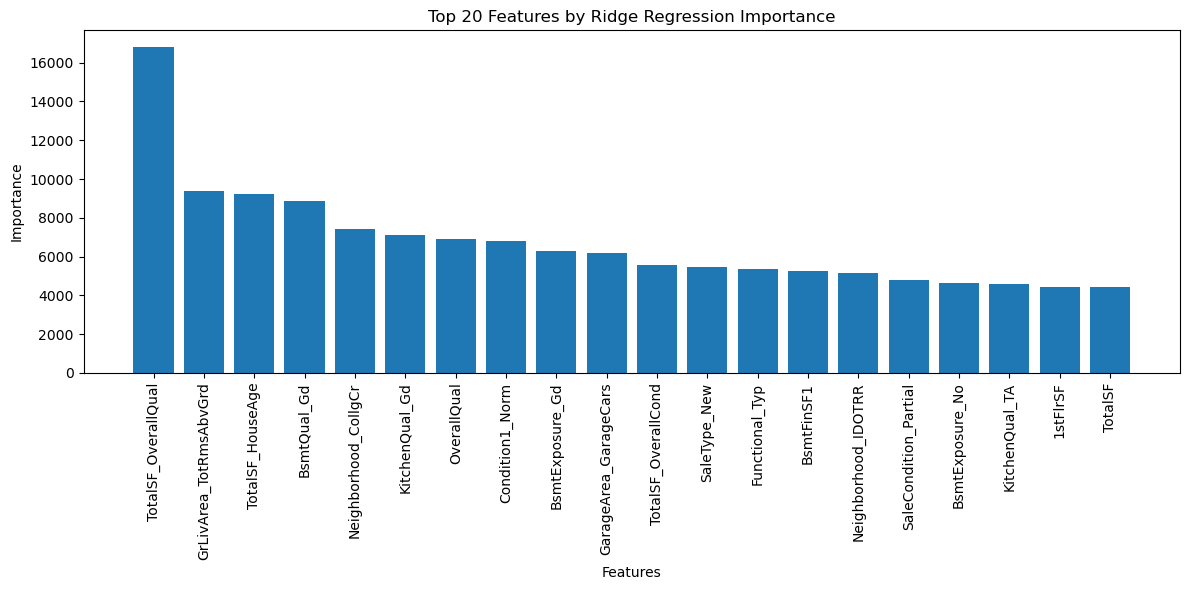

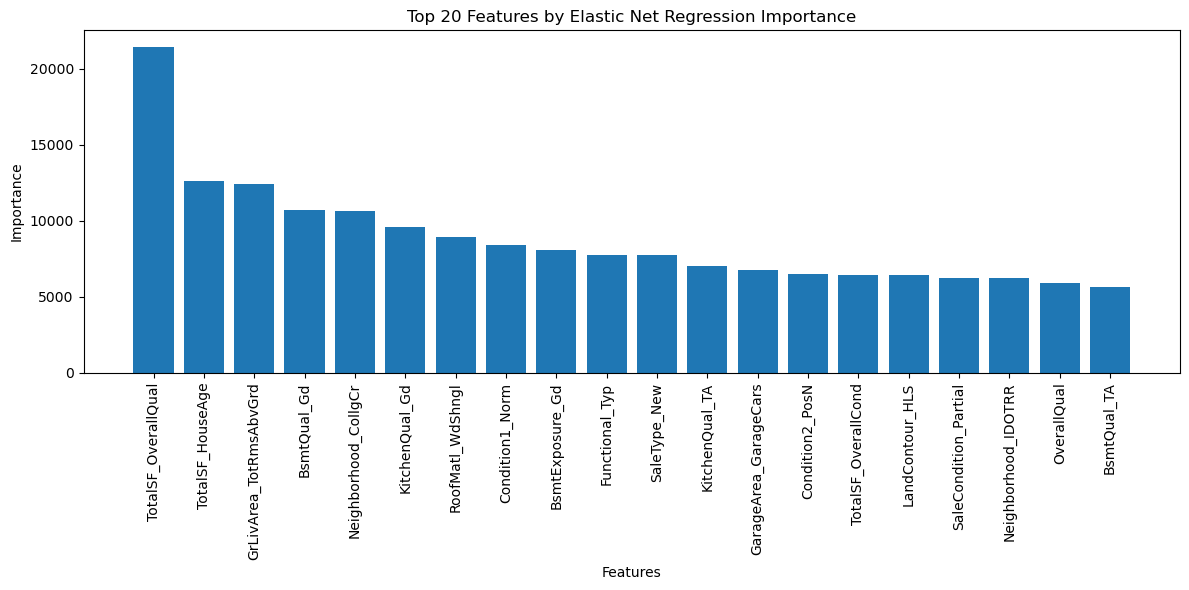


Top 10 features with the largest difference in importance between Ridge and Elastic Net:
                   feature  importance_ridge  importance_elastic_net  \
0      TotalSF_OverallQual      16828.300381            21457.381015   
21        RoofMatl_WdShngl       4383.189683             8956.274416   
38         Condition2_PosN       2994.396693             6492.686731   
2         TotalSF_HouseAge       9210.474421            12609.509913   
4     Neighborhood_CollgCr       7410.761514            10620.539494   
1   GrLivArea_TotRmsAbvGrd       9394.655219            12447.607815   
30         LandContour_HLS       3723.297056             6412.159405   
41         Condition2_Norm       2790.629673             5337.904785   
5           KitchenQual_Gd       7102.852626             9626.433863   
89          KitchenQual_Fa       1395.687334             3816.403041   

    importance_difference  
0            -4629.080634  
21           -4573.084732  
38           -3498.290038  
2    

In [190]:
# Ridge and Elastic Net

from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def custom_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def custom_scoring():
    return {
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error',
        'MAPE': make_scorer(custom_mape, greater_is_better=False),
        'MedAE': 'neg_median_absolute_error',
        'R2': 'r2',
        'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    }

# Ridge Regression
ridge_params = {'alpha': [0.1, 1, 10, 100, 1000]}
ridge = GridSearchCV(Ridge(random_state=42), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge.fit(X_processed, y)
best_ridge = ridge.best_estimator_
ridge_scores = cross_validate(best_ridge, X_processed, y, cv=5, scoring=custom_scoring())

# Elastic Net
elastic_net_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [100000],
    'tol': [1e-4]
}
elastic_net = GridSearchCV(ElasticNet(random_state=42), elastic_net_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elastic_net.fit(X_processed, y)
best_elastic_net = elastic_net.best_estimator_
elastic_net_scores = cross_validate(best_elastic_net, X_processed, y, cv=5, scoring=custom_scoring())

def print_scores(model_name, scores):
    print(f"\n{model_name} Results:")
    for metric, values in scores.items():
        if metric.startswith('test_'):
            metric_name = metric[5:]
            mean = np.mean(values)
            std = np.std(values)
            if metric_name in ['MAE', 'MSE', 'MedAE', 'RMSE', 'MAPE']:
                print(f"{metric_name}: {-mean:.4f} (+/- {std * 2:.4f})")
            else:
                print(f"{metric_name}: {mean:.4f} (+/- {std * 2:.4f})")
    
    mse = -np.mean(scores['test_MSE'])
    print(f"RMSE (calculated from MSE): {np.sqrt(mse):.4f}")

print(f"Best Ridge alpha: {ridge.best_params_['alpha']}")
print_scores("Ridge Regression", ridge_scores)
print(f"\nBest Elastic Net parameters: {elastic_net.best_params_}")
print_scores("Elastic Net Regression", elastic_net_scores)

# Feature Importance for Ridge Regression
ridge_importances = pd.DataFrame({'feature': feature_names, 'importance': np.abs(best_ridge.coef_)})
ridge_importances = ridge_importances.sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 features by Ridge importance:")
print(ridge_importances.head(10))

# Feature Importance for Elastic Net
elastic_net_importances = pd.DataFrame({'feature': feature_names, 'importance': np.abs(best_elastic_net.coef_)})
elastic_net_importances = elastic_net_importances.sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 features by Elastic Net importance:")
print(elastic_net_importances.head(10))

# Visualize feature importance
def plot_feature_importance(importances, title):
    plt.figure(figsize=(12, 6))
    plt.bar(importances['feature'][:20], importances['importance'][:20])
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importance(ridge_importances, 'Top 20 Features by Ridge Regression Importance')
plot_feature_importance(elastic_net_importances, 'Top 20 Features by Elastic Net Regression Importance')

# Compare feature importance
combined_importances = pd.merge(ridge_importances, elastic_net_importances, on='feature', suffixes=('_ridge', '_elastic_net'))
combined_importances['importance_difference'] = combined_importances['importance_ridge'] - combined_importances['importance_elastic_net']
combined_importances = combined_importances.sort_values('importance_difference', key=abs, ascending=False)

print("\nTop 10 features with the largest difference in importance between Ridge and Elastic Net:")
print(combined_importances.head(10))

In [191]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Split the processed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Calculate performance metrics
mae = -cross_val_score(rf_model, X_processed, y, cv=5, scoring='neg_mean_absolute_error')
mse = -cross_val_score(rf_model, X_processed, y, cv=5, scoring='neg_mean_squared_error')
rmse = np.sqrt(mse)
mape = -cross_val_score(rf_model, X_processed, y, cv=5, scoring='neg_mean_absolute_percentage_error')
medae = -cross_val_score(rf_model, X_processed, y, cv=5, scoring='neg_median_absolute_error')
r2 = cross_val_score(rf_model, X_processed, y, cv=5, scoring='r2')

# Print the results
print("Cross-validation results:")
print(f"Mean Absolute Error: {mae.mean():.2f} (+/- {mae.std() * 2:.2f})")
print(f"Mean Squared Error: {mse.mean():.2f} (+/- {mse.std() * 2:.2f})")
print(f"Root Mean Squared Error: {rmse.mean():.2f} (+/- {rmse.std() * 2:.2f})")
print(f"Mean Absolute Percentage Error: {mape.mean():.2f}% (+/- {mape.std() * 2:.2f}%)")
print(f"Median Absolute Error: {medae.mean():.2f} (+/- {medae.std() * 2:.2f})")
print(f"R-squared: {r2.mean():.3f} (+/- {r2.std() * 2:.3f})")

# If you want to calculate metrics on the test set as well:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = rf_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Calculate MAPE
test_medae = median_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nTest set results:")
print(f"Test Mean Absolute Error: {test_mae:.2f}")
print(f"Test Mean Squared Error: {test_mse:.2f}")
print(f"Test Root Mean Squared Error: {test_rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {test_mape:.2f}%")
print(f"Test Median Absolute Error: {test_medae:.2f}")
print(f"Test R-squared: {test_r2:.4f}")

Cross-validation results:
Mean Absolute Error: 17508.05 (+/- 2041.90)
Mean Squared Error: 927232894.06 (+/- 506114186.23)
Root Mean Squared Error: 30176.95 (+/- 8144.78)
Mean Absolute Percentage Error: 0.10% (+/- 0.01%)
Median Absolute Error: 11101.34 (+/- 2006.31)
R-squared: 0.853 (+/- 0.065)

Test set results:
Test Mean Absolute Error: 17107.39
Test Mean Squared Error: 887917562.16
Test Root Mean Squared Error: 29797.95
Test Mean Absolute Percentage Error: 10.08%
Test Median Absolute Error: 9078.64
Test R-squared: 0.8842


In [192]:
# Feature Importance in Random Forest
# Get the feature names from the preprocessed data
feature_names = full_pipeline.named_steps['preprocess_and_engineer'].transform(X).attrs['feature_names']

# Feature Importance in Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

print(f"Number of feature names: {len(feature_names)}")
print(f"Number of feature importances: {len(rf_model.feature_importances_)}")

feature_importance = pd.DataFrame({
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance['feature'] = feature_names if len(feature_names) == len(rf_model.feature_importances_) else [f"Feature_{i}" for i in range(len(rf_model.feature_importances_))]

print(feature_importance.head(10))


Number of features before preprocessing:
Numeric: 51
Categorical: 43
Year: 3

Categorical feature encoding details:
MSZoning: 5 categories, 4 encoded features
Street: 2 categories, 1 encoded features
Alley: 3 categories, 2 encoded features
LotShape: 4 categories, 3 encoded features
LandContour: 4 categories, 3 encoded features
Utilities: 2 categories, 1 encoded features
LotConfig: 5 categories, 4 encoded features
LandSlope: 3 categories, 2 encoded features
Neighborhood: 10 categories, 9 encoded features
Condition1: 9 categories, 8 encoded features
Condition2: 8 categories, 7 encoded features
BldgType: 5 categories, 4 encoded features
HouseStyle: 8 categories, 7 encoded features
RoofStyle: 6 categories, 5 encoded features
RoofMatl: 8 categories, 7 encoded features
Exterior1st: 10 categories, 9 encoded features
Exterior2nd: 10 categories, 9 encoded features
MasVnrType: 5 categories, 4 encoded features
ExterQual: 4 categories, 3 encoded features
ExterCond: 5 categories, 4 encoded features

In [193]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import numpy as np

# Initialize the model
gbdt_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gbdt_model.fit(X_train, y_train)

# Calculate performance metrics using cross-validation on the training data
mae = -cross_val_score(gbdt_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mse = -cross_val_score(gbdt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse = np.sqrt(mse)
mape = -cross_val_score(gbdt_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
medae = -cross_val_score(gbdt_model, X_train, y_train, cv=5, scoring='neg_median_absolute_error')
r2 = cross_val_score(gbdt_model, X_train, y_train, cv=5, scoring='r2')

# Calculate performance on the test set
y_pred = gbdt_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_medae = median_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("Cross-validation results (on training data):")
print(f"Mean Absolute Error: {mae.mean():.2f} (+/- {mae.std() * 2:.2f})")
print(f"Mean Squared Error: {mse.mean():.2f} (+/- {mse.std() * 2:.2f})")
print(f"Root Mean Squared Error: {rmse.mean():.2f} (+/- {rmse.std() * 2:.2f})")
print(f"Mean Absolute Percentage Error: {mape.mean():.2f}% (+/- {mape.std() * 2:.2f}%)")
print(f"Median Absolute Error: {medae.mean():.2f} (+/- {medae.std() * 2:.2f})")
print(f"R-squared: {r2.mean():.3f} (+/- {r2.std() * 2:.3f})")

print("\nTest set results:")
print(f"Test Mean Absolute Error: {test_mae:.2f}")
print(f"Test Mean Squared Error: {test_mse:.2f}")
print(f"Test Root Mean Squared Error: {test_rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {test_mape:.2f}%")
print(f"Test Median Absolute Error: {test_medae:.2f}")
print(f"Test R-squared: {test_r2:.4f}")

Cross-validation results (on training data):
Mean Absolute Error: 16781.62 (+/- 2367.53)
Mean Squared Error: 952736192.96 (+/- 595446171.84)
Root Mean Squared Error: 30463.69 (+/- 9939.74)
Mean Absolute Percentage Error: 0.09% (+/- 0.02%)
Median Absolute Error: 10261.96 (+/- 1766.09)
R-squared: 0.839 (+/- 0.094)

Test set results:
Test Mean Absolute Error: 17235.39
Test Mean Squared Error: 894802001.38
Test Root Mean Squared Error: 29913.24
Test Mean Absolute Percentage Error: 9.99%
Test Median Absolute Error: 10783.95
Test R-squared: 0.8833


In [208]:
# Comparing GBDT, XGBoost, and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import numpy as np

# XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# LightGBM model
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train, y_train)

# Function to calculate and print metrics
def print_metrics(model, X, y, model_name):
    mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(mse)
    mape = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')
    medae = -cross_val_score(model, X, y, cv=5, scoring='neg_median_absolute_error')
    r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    print(f"{model_name} Cross-validation results:")
    print(f"Mean Absolute Error: {mae.mean():.2f} (+/- {mae.std() * 2:.2f})")
    print(f"Mean Squared Error: {mse.mean():.2f} (+/- {mse.std() * 2:.2f})")
    print(f"Root Mean Squared Error: {rmse.mean():.2f} (+/- {rmse.std() * 2:.2f})")
    print(f"Mean Absolute Percentage Error: {mape.mean():.2f}% (+/- {mape.std() * 2:.2f}%)")
    print(f"Median Absolute Error: {medae.mean():.2f} (+/- {medae.std() * 2:.2f})")
    print(f"R-squared: {r2.mean():.3f} (+/- {r2.std() * 2:.3f})")
    
    y_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    test_medae = median_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Test set results:")
    print(f"Test Mean Absolute Error: {test_mae:.2f}")
    print(f"Test Mean Squared Error: {test_mse:.2f}")
    print(f"Test Root Mean Squared Error: {test_rmse:.2f}")
    print(f"Test Mean Absolute Percentage Error: {test_mape:.2f}%")
    print(f"Test Median Absolute Error: {test_medae:.2f}")
    print(f"Test R-squared: {test_r2:.4f}\n")

# Print metrics for all models
print_metrics(gbdt_model, X_train, y_train, "GBDT")
print_metrics(xgb_model, X_train, y_train, "XGBoost")
print_metrics(lgbm_model, X_train, y_train, "LightGBM")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6103
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 178
[LightGBM] [Info] Start training from score 181441.541952
GBDT Cross-validation results:
Mean Absolute Error: 16781.62 (+/- 2367.53)
Mean Squared Error: 952736192.96 (+/- 595446171.84)
Root Mean Squared Error: 30463.69 (+/- 9939.74)
Mean Absolute Percentage Error: 0.09% (+/- 0.02%)
Median Absolute Error: 10261.96 (+/- 1766.09)
R-squared: 0.839 (+/- 0.094)

GBDT Test set results:
Test Mean Absolute Error: 17235.39
Test Mean Squared Error: 894802001.38
Test Root Mean Squared Error: 29913.24
Test Mean Absolute Percentage Error: 9.99%
Test Median Absolute Error: 10783.95
Test R-squared: 0.8833

XGBoost Cross-validation results:
Mean Absolute Error: 17753.33 (+/- 2364.02)
Mean Squared Error: 1176863372.64 (